# 🍔👁 Food Vision: fine tunning Efficentnet with food_101 dataset

In these notebook I`m going to build a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data for training (25250 training images and 7570 testing images). After that, I'm going to reproduce the same model with all of the data from the Food101 dataset.
The goal to achive for these project is **beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network **trained for 2-3 days to achieve 77.4% top-1 accuracy**.

In these project you can see the following steps:
- 1. Creation of a small CNN to see how they works
- 2. Transfer Learning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model, a state of the art computer vision architecture trained with [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks. In these case, I'm going to use the 10% of the data of the Food_101 dataset.
- 3. Fine tune the [EfficientNet](https://arxiv.org/abs/1905.11946) model with 10 % of the data.
- 4. Develop the same EfficentNet model as above but with the **100% of the Food_101 dataset**.


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-12-01 15:15:34.051808


- In the repository you can download the *helper_functions.py* file, with developed functions that are so useful for these and other projects of Convolutional Neural Networks

In [2]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/Garcialejan/Computer_vision_food_classification/refs/heads/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [47]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, walk_through_dir, create_checkpoint_callback, compare_historys, make_confusion_matrix

- Now, I'm going to import some of the modules that we need to run the code, check the tensorflow version and check if we are using the GPU for run our models.

In [5]:
import tensorflow as tf

In [6]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [7]:
# Get GPU name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-0cb8d0d0-b8f3-ea57-552f-290eacf87dec)


In [ ]:
# I reduce the logs outputs with:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only shows warnings and errors

# Models with 10 % of the data

## 1. Loading the data.

In [9]:
train_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train"
test_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test"

In [10]:
walk_through_dir("/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/donuts'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/sushi'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 75 images

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image_direct(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" +target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


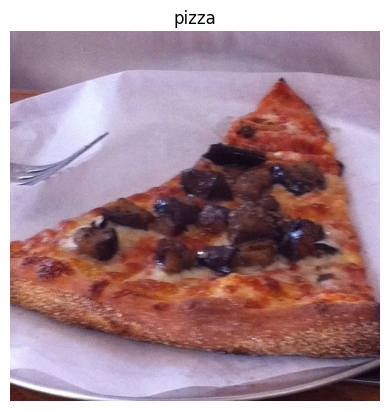

In [12]:
img = view_random_image_direct(target_dir=train_dir, target_class="pizza")

In [13]:
img

array([[[143, 124, 146],
        [141, 122, 144],
        [149, 130, 152],
        ...,
        [143, 118, 139],
        [144, 119, 138],
        [144, 119, 138]],

       [[147, 128, 150],
        [145, 126, 148],
        [147, 128, 150],
        ...,
        [144, 119, 140],
        [145, 120, 139],
        [146, 121, 140]],

       [[139, 120, 142],
        [142, 123, 145],
        [147, 128, 150],
        ...,
        [148, 123, 144],
        [152, 127, 146],
        [157, 132, 151]],

       ...,

       [[ 85,  36,  29],
        [ 82,  33,  26],
        [ 82,  33,  26],
        ...,
        [ 84,  35,  28],
        [ 84,  35,  28],
        [ 84,  35,  28]],

       [[ 89,  39,  32],
        [ 86,  36,  29],
        [ 85,  35,  28],
        ...,
        [ 79,  29,  20],
        [ 80,  30,  21],
        [ 80,  30,  21]],

       [[ 86,  36,  29],
        [ 86,  36,  29],
        [ 85,  35,  28],
        ...,
        [ 88,  38,  29],
        [ 92,  42,  33],
        [ 94,  44,  35]]

In [14]:
print(img.min(), img.max())

0 255


- Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`
- All of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.
- To work with normalize data, we are going to use one of the most common preprocessing steps for working with images, which is to **scale** (also referred to as **normalize**) the pixel values by dividing the image arrays by 255. We are going to do this step of normalize the data in a layer using the Sequential API of tensorflow.

- Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

In [26]:
# Create data inputs 
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 25250 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [27]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

- The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

In [28]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

- I'm going to create a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callbacks to save the progress during training. This means I could experiment with further training later without having to train from scratch every time.
- This maybe is making non sense to you becouse I'm developing a small CNN, however this callback will be useful when we see the EfficentNet transfer learning and fine tunning models.  

In [29]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name = "model1_checkpoint.weights.h5"

chk_callback_model1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + checkpoint_name,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

## 2. First CNN: base_model

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

model_1 = tf.keras.models.Sequential([
    layers.Rescaling(1./255,
                     input_shape=(224, 224, 3)),
    layers.Conv2D(filters=10,
                  kernel_size=3, 
                  activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2, padding="valid"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")
])

In [31]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [32]:
# Fit the model
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent,
                        callbacks=[chk_callback_model1])

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.0191 - loss: 0.0666 - val_accuracy: 0.0421 - val_loss: 0.0535
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.0650 - loss: 0.0520 - val_accuracy: 0.0768 - val_loss: 0.0522
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1979 - loss: 0.0451 - val_accuracy: 0.0634 - val_loss: 0.0612
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4629 - loss: 0.0315 - val_accuracy: 0.0517 - val_loss: 0.0837
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8038 - loss: 0.0138 - val_accuracy: 0.0481 - val_loss: 0.1362


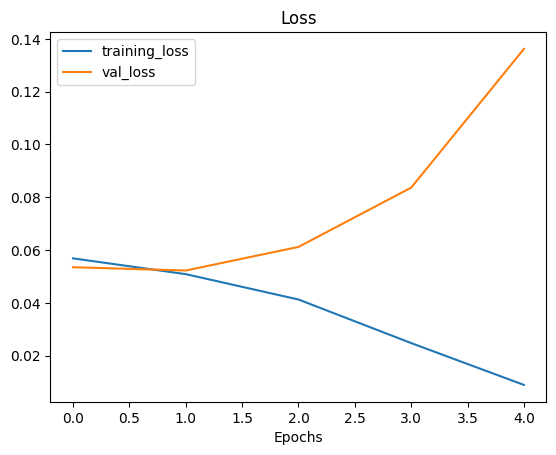

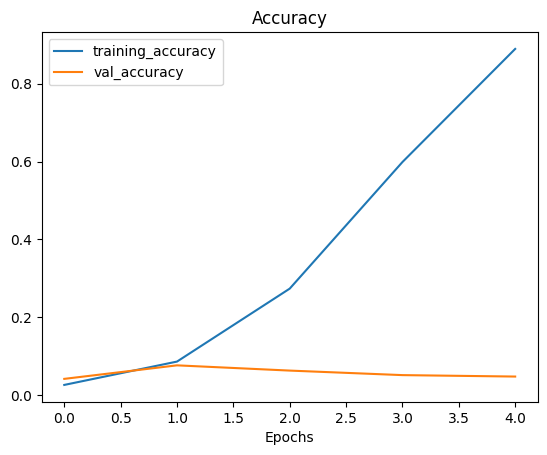

In [33]:
# How does the model go
plot_loss_curves(history_1)

- Well, as you can see, **overfitting** has come to the party. Let's try something to avoid it.
- For the other hand, I'm going to add some extra features to the CNN to get a better accuracy value

In [34]:
model_2 = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  
    layers.Conv2D(32, 3, activation="relu"),             # More filters in the initial layers
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(64, 3, activation="relu"),             # We add progressively more filters
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),                                 # Dropout to avoid overfitting
    layers.Dense(128, activation="relu"),                # New fully connected layer
    layers.Dropout(0.5),                                 # More dropout to avoid overfitting
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")  # Salida softmax
])

In [35]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent)

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0123 - loss: 0.1176 - val_accuracy: 0.0302 - val_loss: 0.0547
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.0196 - loss: 0.0597 - val_accuracy: 0.0510 - val_loss: 0.0533
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0345 - loss: 0.0570 - val_accuracy: 0.0581 - val_loss: 0.0525
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.0517 - loss: 0.0558 - val_accuracy: 0.0760 - val_loss: 0.0514
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.0620 - loss: 0.0546 - val_accuracy: 0.0863 - val_loss: 0.0504


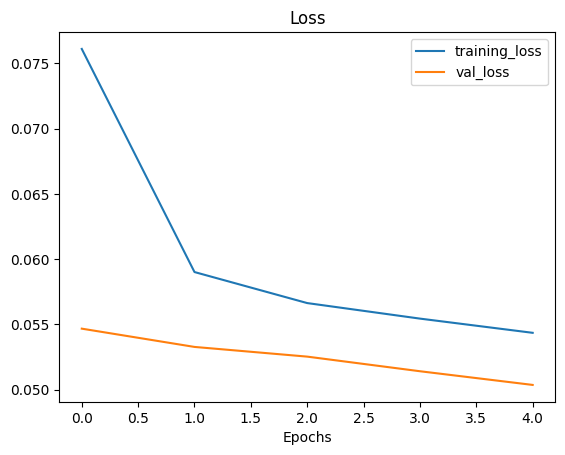

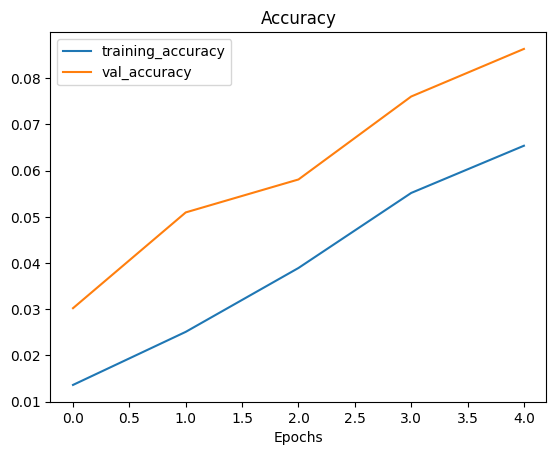

In [36]:
plot_loss_curves(history_2)

- I have reduced the overfitting, however I'm far away from my goal of getting an accuracy better than the [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) project.

- No problem, to solve this I am going to use transfer learning and fine tunning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model.

## 3. Transfer learning with EfficientNet and 10% of the data

- Now, I'm going to use the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module that contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct the new model. 
- In particular, I'm going to use the [EfficientNet](https://arxiv.org/abs/1905.11946) model setting the `include_top` parameter to `False` (create our own top, which are the output layers for the model).
- Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.

In [37]:
# Reload the images
IMG_SIZE = (224, 224) 
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 25250 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [38]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

### 3.1 Adding data augmentation and normalize images

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. Doing this simulates the kind of data a model might be used on in the real world.

- To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

In [39]:
data_augmentation = keras.Sequential([
  layers.Input(shape = (224, 224, 3)),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255)
], name ="data_augmentation")

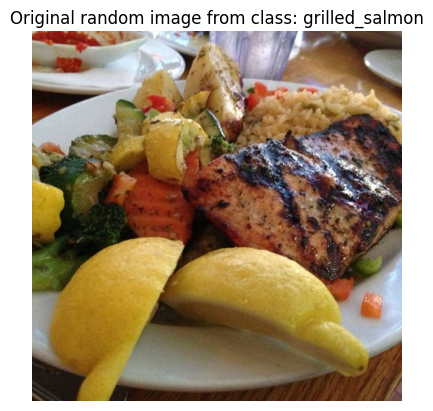

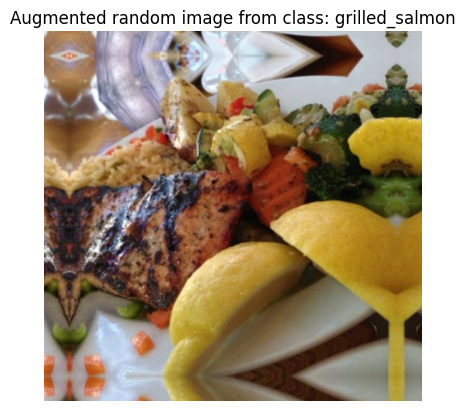

In [40]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = train_dir + "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()

plt.imshow(tf.squeeze(augmented_img)/255) # eliminate te batch dimension
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

- The `EfficientNetV2` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do

In [ ]:
# We are going to see the summary of the EfficentNetV2 model
# You can see that the 3 layer is a normalization layer
base_model.summary()

### 3.2 Model creation and trainning

In [ ]:
def create_transfer_learning_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                                   output_shape: int = 101,
                                   learning_rate: float = 0.001,
                                   training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B3 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:
# Create an instance of model_3
model_3 = create_transfer_learning_model()

In [43]:
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, None, None,     │    12,930,622 │
│                                 │ 1536)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       155,237 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,085,859 (49.92 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [45]:
# Create checkpoint callback to save model for later use
checkpoint_path_model3 = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name_model3 = "model3_checkpoint.weights.h5"

chk_callback_model3 = create_checkpoint_callback(checkpoint_path_model3,
                                                 checkpoint_name_model3)

In [46]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_3 = model_3.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                        callbacks = [chk_callback_model3])

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 305s 376ms/step - accuracy: 0.2809 - loss: 3.2338 - val_accuracy: 0.5117 - val_loss: 1.8904
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 200s 253ms/step - accuracy: 0.5116 - loss: 1.9324 - val_accuracy: 0.5567 - val_loss: 1.7438
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.5490 - loss: 1.7436 - val_accuracy: 0.5794 - val_loss: 1.6722
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 123s 156ms/step - accuracy: 0.5733 - loss: 1.6322 - val_accuracy: 0.6022 - val_loss: 1.5481
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5895 - loss: 1.5565

2024-12-01 15:39:50.054003: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-01 15:39:50.054337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


790/790 ━━━━━━━━━━━━━━━━━━━━ 110s 139ms/step - accuracy: 0.5895 - loss: 1.5565 - val_accuracy: 0.6957 - val_loss: 1.0378


In [48]:
# Evaluate on the test data
results_model_3= model_3.evaluate(test_data_10_percent)
results_model_3

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.5906 - loss: 1.5897


[1.5794321298599243, 0.5992079377174377]

In [50]:
# Load in saved model weights and evaluate model
model_3.load_weights(checkpoint_path_model3 + checkpoint_name_model3)
loaded_weights_model3_results = model_3.evaluate(test_data_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5868 - loss: 1.6035


In [52]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_model_3), np.array(loaded_weights_model3_results))

array([ True,  True])

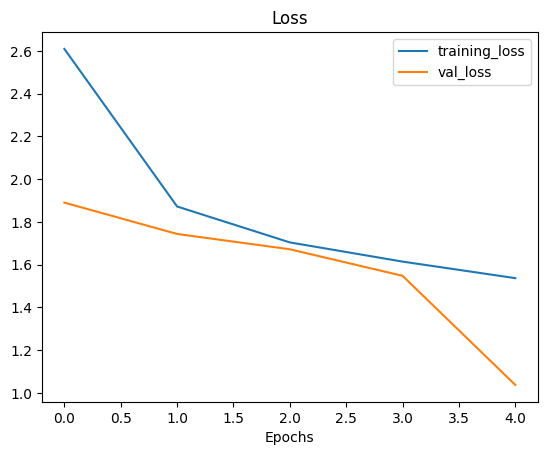

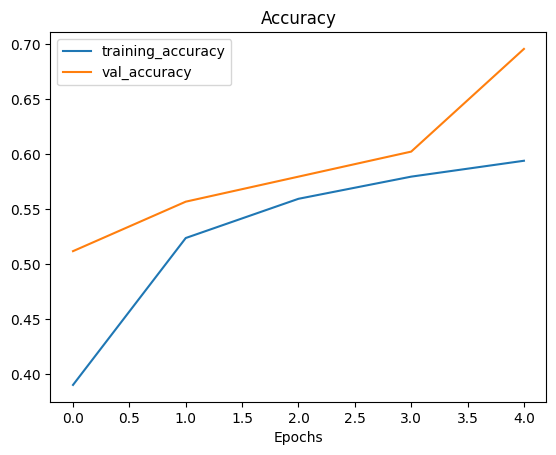

In [53]:
# Plot model loss curves
plot_loss_curves(history_3)

- So nice!! I take a near 60% of accuracy with only 10% of the data thanks to transfer learning!!
- And it's not over yet, now I'm going to implement fine-tunnning to try to improve the accuracy of fine-tunnning even more.

## 4. Fine tunning with EfficientNet and 10% of the data

- The feature extraction transfer learning model performs well, but now I'm going to try to **fine-tune a few layers** in the base model and see if I take any improvement.The good news is, thanks to the `ModelCheckpoint` callback, I've got the saved weights of the already well-performing model so if fine-tuning doesn't add any benefits, I can revert back.
- To fine-tune the base model I will first set its `trainable` attribute to `True`, unfreezing all of the frozen. Then I will refreeze every layer **except for the last 5**, making them trainable.

In [54]:
# 1. Unfreeze all of the layers in the base model
base_model.trainable = True

# 2. Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [55]:
# Recompile model with lower learning rate
model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

- Because I'm fine-tuning, I use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [58]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_4 False
1 rescaling_4 False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv Fal

In [59]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

histroy_efficentnet_fine_tuned = model_3.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data_10_percent,
                                             validation_steps=int(0.15 * len(test_data_10_percent)), # validate on 15% of the test data
                                             initial_epoch=history_3.epoch[-1]) # start from previous last epoch

Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 102s 120ms/step - accuracy: 0.6172 - loss: 1.4720 - val_accuracy: 0.5911 - val_loss: 1.5638
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 91s 115ms/step - accuracy: 0.6196 - loss: 1.4546 - val_accuracy: 0.5991 - val_loss: 1.5609
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.6248 - loss: 1.4228 - val_accuracy: 0.6143 - val_loss: 1.5292
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.6292 - loss: 1.4119 - val_accuracy: 0.6045 - val_loss: 1.5984
Epoch 9/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.6309 - loss: 1.4157 - val_accuracy: 0.6330 - val_loss: 1.4790
Epoch 10/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 87ms/step - accuracy: 0.6316 - loss: 1.3961 - val_accuracy: 0.6232 - val_loss: 1.4746


In [60]:
# Evaluate fine-tuned model
results_all_classes_10_percent_fine_tune = model_3.evaluate(test_data_10_percent)
results_all_classes_10_percent_fine_tune

237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6032 - loss: 1.5333


[1.5107585191726685, 0.6139934062957764]

- To take a better picture of how is fine tunning working I'm going to use the `compare_historys()` function and see what the training curves say.

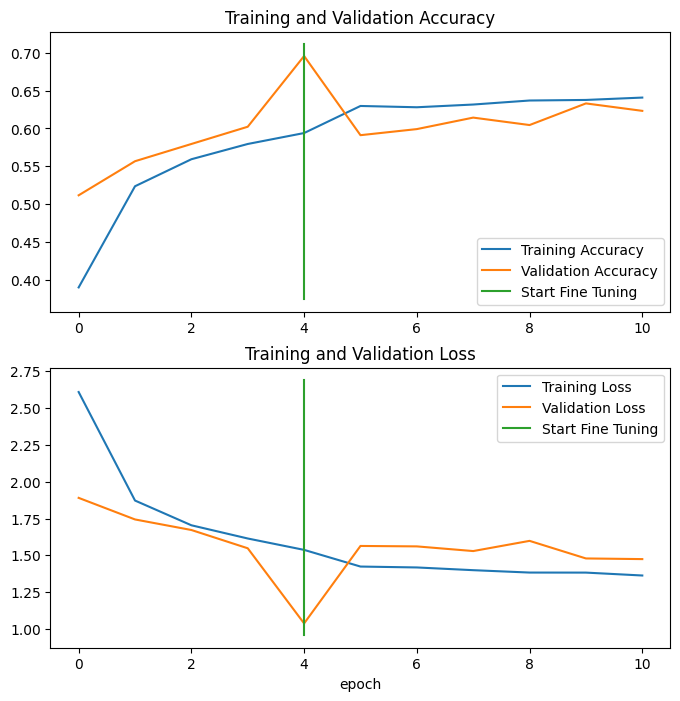

In [61]:
compare_historys(original_history=history_3,
                 new_history=histroy_efficentnet_fine_tuned,
                 initial_epochs=5)

- It seems that after fine-tuning, the model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 
- This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.
- If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## 5. Evaluating the performance of the best fine tuned model

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)